In [89]:
import import_ipynb
from Functions import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt
import time

In [90]:
def Extract(Params):
    C = Params['C']
    P = Params['P']
    F = Params['F']
    B = Params['B']
    KP = Params['KP']
    KPast = Params['KPast']
    KFuture = Params['KFuture']
    return C,P,F,B,KP,KPast,KFuture

## Generate Random Values for Parameters

In [91]:
def Gen_Params(Size,N):
    C = torch.rand((1,3,Size[0],Size[1]),requires_grad=True)
    P = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    F = [torch.rand((1,3,Size[0],Size[1]),requires_grad=True) for _ in range(N)]
    B = torch.rand((1,3,Size[0],Size[1]),requires_grad=True)
    KP = torch.rand((3,3,3,3),requires_grad=True)
    KPast = [torch.rand((3,3,3,3),requires_grad=True) for _ in range(N)]
    KFuture = [torch.rand((3,3,3,3),requires_grad=True) for _ in range(N)]
    return C,P,F,B,KP,KPast,KFuture

## Objective Function

In [92]:
def ObjFun(Current,Past,Future,C,P,F,B,KP,KPast,KFuture):
    currentF = torch.fft.fft2(Current)
    pastF = [torch.fft.fft2(p) for p in Past]
    futureF = [torch.fft.fft2(f) for f in Future]
    sumF = C*currentF
    for pf,p in zip(pastF,P):
        sumF = sumF + pf*p
    for ff,f in zip(futureF,F):
        sumF = sumF + ff*f
    sumF = sumF + B
    SumP = torch.fft.ifft2(sumF).real
    Pred = Fun.leaky_relu(Fun.conv2d(SumP,KP,stride=1,padding=1))
    for kp,p in zip(KPast,Past):
        Pred = Pred + Fun.leaky_relu(Fun.conv2d(p,kp,stride=1,padding=1))
    for kf,f in zip(KFuture,Future):
        Pred = Pred + Fun.leaky_relu(Fun.conv2d(f,kf,stride=1,padding=1))
    return Pred

## Draw Inconsistencies and noise to frame

In [93]:
def AddOneInc1(F,):
    if isinstance(F, torch.Tensor):
        # Convert to NumPy Array
        F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 4 * I.shape[0] // 5), random.randint(0, 4 * I.shape[1] // 5)
    # Random size
    xl,yl = random.randint(x+1,x+50),random.randint(y+1,y+50)
    # Random option
    Op = random.randint(0, 8)
    if Op == 0: #Draw square with changes color ranges
        I[x:xl, y:yl] = change_range_colors(I[x:xl,y:yl], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1: #Draw square with random color
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:xl,y:yl] = change_range_colors(I[x:xl,y:yl], (R, G, B), (R, G, B))
    elif Op == 2: #Draw line with random color
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//15)
        I = cv2.line(I, (x, y), (xl,yl), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3: #Draw black line
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//20)
        I = cv2.line(I, (x, y), (xl, yl), (0, 0, 0), Thick)  
    elif Op == 4: #Add a square of noise
        I[x:xl,y:yl] = I[x:xl,y:yl] + np.random.random_integers(-10,10,I[x:xl,y:yl].shape)
    elif Op == 5: #Convolution with a random kernel
        kernel = np.random.rand(3,3)
        I[x:xl,y:yl] = cv2.filter2D(I[x:xl,y:yl],-1,kernel)
    elif Op == 6:
        I[x:xl,y:yl] = img_deformation(I[x:xl,y:yl])
    else:# Op == 7:
        I[x:xl,y:yl] = random_point_warp(I[x:xl,y:yl])
    #else:
         #I[x:xl,y:yl] = random_PRR(I[x:xl,y:yl])
    # Convert back to tensor
    I_tensor = torch.tensor(I,dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

## Optical Flow Function

In [94]:
def OF(img1: torch.Tensor, img2: torch.Tensor, alpha: float = 1.0, iterations: int = 100):
    assert img1.shape == img2.shape, "Images must have the same shape"
    # Convert to grayscale to simplify optical flow calculation
    def rgb_to_grayscale(img):
        return 0.2989 * img[0,0, :, :] + 0.5870 * img[0,1, :, :] + 0.1140 * img[0,2, :, :]

    I1 = rgb_to_grayscale(img1)
    I2 = rgb_to_grayscale(img2)

    # Initialize optical flow vectors (u for x direction, v for y direction)
    u = torch.zeros_like(I1, requires_grad=True)
    v = torch.zeros_like(I1, requires_grad=True)
    
    # Define convolution kernels for gradients
    kernel_x = torch.tensor([[[[-1, 1], [-1, 1]]]], dtype=torch.float32)
    kernel_y = torch.tensor([[[[-1, -1], [1, 1]]]], dtype=torch.float32)

    # Compute gradients with padding that maintains the original image size
    Ix = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_x, padding=(0, 1)).squeeze(0).squeeze(0)
    Iy = Fun.conv2d(I1.unsqueeze(0).unsqueeze(0), kernel_y, padding=(1, 0)).squeeze(0).squeeze(0)
    It = I2 - I1  # Temporal gradient

    # Ensure all tensors have matching dimensions by cropping to the smallest dimensions
    min_h = min(Ix.shape[-2], Iy.shape[-2], It.shape[-2], I1.shape[-2])
    min_w = min(Ix.shape[-1], Iy.shape[-1], It.shape[-1], I1.shape[-1])

    # No additional indexing needed here
    Ix = Ix[:min_h, :min_w]
    Iy = Iy[:min_h, :min_w]
    It = It[:min_h, :min_w]
    u = u[:min_h, :min_w]
    v = v[:min_h, :min_w]

    # Iteratively update the optical flow
    for _ in range(iterations):
        # Average flow in the neighborhood
        u_avg = Fun.avg_pool2d(u.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        v_avg = Fun.avg_pool2d(v.unsqueeze(0).unsqueeze(0), 3, stride=1, padding=1).squeeze(0).squeeze(0)
        
        # Optical flow update step based on Horn-Schunck method
        P = Ix * u_avg + Iy * v_avg + It
        D = alpha ** 2 + Ix ** 2 + Iy ** 2
        
        u = u_avg - (Ix * P) / D
        v = v_avg - (Iy * P) / D

    # Stack u and v to form the flow tensor
    flow = torch.stack((u, v), dim=0)
    return flow

In [95]:
def hist(image, num_bins=256, min_val=0.0, max_val=1.0):
    # Rescale the image to the range [0, num_bins]
    image_scaled = (image - min_val) / (max_val - min_val) * (num_bins - 1)
    # Create bin centers
    bin_centers = torch.linspace(0, num_bins - 1, num_bins, device=image.device)
    # Expand bin centers for broadcasting
    bin_centers = bin_centers.view(1, 1, 1, -1)
    # Compute the soft assignment (weights) to each bin using Gaussian kernel
    histograms = torch.exp(-(image_scaled.unsqueeze(-1) - bin_centers) ** 2)
    # Sum over all pixels to get the histogram
    histograms = histograms.sum(dim=[2, 3])  # Sum over height and width
    # Normalize the histogram to sum to 1
    histograms = histograms / histograms.sum(dim=-1, keepdim=True)
    return histograms

def histogram_loss(image_gen, image_target, num_bins=256):
    # Ensure images are in the range [0, 1]
    image_gen = torch.clamp(image_gen, 0.0, 1.0)
    image_target = torch.clamp(image_target, 0.0, 1.0)
    # Calculate differentiable histograms for generated and target images
    hist_gen = hist(image_gen, num_bins=num_bins)
    hist_target = hist(image_target, num_bins=num_bins)
    # Calculate the histogram difference (L2 norm for histogram loss)
    loss = torch.sum((hist_gen - hist_target) ** 2, dim=-1).mean()
    return loss

In [96]:
def frequency_loss(image1, image2):
    # Apply 2D Fourier Transform to the images along the height and width dimensions
    freq_image1 = torch.fft.fft2(image1*255, dim=(-2, -1))
    freq_image2 = torch.fft.fft2(image2*255, dim=(-2, -1))
    # Compute the magnitude of the frequencies (ignore the phase for this loss)
    mag_image1 = torch.abs(freq_image1)
    mag_image2 = torch.abs(freq_image2)
    # Compute the loss between the magnitudes of the frequency components
    loss = Fun.mse_loss(mag_image1, mag_image2)
    return loss

In [97]:
def read_random_video(directory, N):
    # Get a random video from the directory
    videos = [f for f in os.listdir(directory) if f.endswith(('.mp4', '.avi', '.mov'))]
    if not videos:
        raise ValueError("No video files found in the directory")
    
    video_path = os.path.join(directory, random.choice(videos))
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file {video_path}")
    
    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure N sequential frames and next N frames can be fetched
    if total_frames < 2 * N + 1:
        raise ValueError(f"Video does not have enough frames for N={N} sequential frames.")
    
    # Randomly select a start frame ensuring there are enough remaining frames
    start_frame = random.randint(0, total_frames - (2 * N + 1))
    
    # Read the first N sequential frames
    sequential_frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading frame from video")
        sequential_frames.append(frame)

    # Read the next single frame
    ret, next_frame = cap.read()
    if not ret:
        raise ValueError("Error reading next frame from video")
    
    # Read the next N sequential frames after the next frame
    next_sequential_frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("Error reading next sequential frame from video")
        next_sequential_frames.append(frame)
    
    # Convert lists to numpy arrays and tensors
    sequential_frames = [np.array(frame) for frame in sequential_frames]
    next_frame = np.array(next_frame)
    next_sequential_frames = [np.array(frame) for frame in next_sequential_frames]
    
    cap.release()
    
    return sequential_frames, next_frame, next_sequential_frames


In [98]:
def warp_image(img: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:

    # Convert image to float32 and normalize to [0.0, 1.0] if it's not already
    if img.dtype == torch.uint8:
        img = img.float() / 255.0
    
    # Image dimensions
    B, C, H, W = img.shape  # B = 1 for this case
    _, Hf, Wf = flow.shape  # Flow dimensions (2, Hf, Wf)
    
    # Crop the image and flow to the smallest common size
    min_H = min(H, Hf)
    min_W = min(W, Wf)
    
    img = img[:, :, :min_H, :min_W]  # Crop image
    flow = flow[:, :min_H, :min_W]   # Crop flow
    
    # Create a meshgrid for pixel coordinates (x, y)
    y_coords, x_coords = torch.meshgrid(torch.arange(min_H), torch.arange(min_W), indexing='ij')
    y_coords = y_coords.to(flow.device).float()
    x_coords = x_coords.to(flow.device).float()
    
    # Add flow vectors to the pixel coordinates
    u, v = flow[0], flow[1]  # Assuming flow is of shape (2, min_H, min_W)
    x_coords_warp = x_coords + u
    y_coords_warp = y_coords + v
    
    # Normalize coordinates to [-1, 1] for grid_sample
    x_coords_warp = 2 * (x_coords_warp / (min_W - 1)) - 1
    y_coords_warp = 2 * (y_coords_warp / (min_H - 1)) - 1

    # Stack x and y coordinates into a flow field grid
    grid = torch.stack((x_coords_warp, y_coords_warp), dim=-1).unsqueeze(0)  # Shape (1, min_H, min_W, 2)

    # Use grid_sample to warp the image
    warped_img = Fun.grid_sample(img, grid, mode='bilinear', padding_mode='border', align_corners=True)

    return warped_img


## Training Function

In [113]:
def train(Path, N_Samples=3, Params=None, N=1, Epochs=10, Steps=5, LR=1e-3, Size=(320,320)):
    if Params is None:
        C, P, F, B, KP, KPast, KFuture = Gen_Params(Size, N)
    else:
        C, P, F, B, KP, KPast, KFuture = Extract(Params)
        N = len(P)
    
    optimizer = optim.NAdam([C, B, KP] + F + P + KPast + KFuture, lr=LR)
    Loss = []  # Loss per epoch
    LossAll = []  # Loss for each sample
    
    # Start time for total time estimation
    total_steps = Epochs * N_Samples
    step_count = 0
    start_time = time.time()
    
    for epoch in range(Epochs):
        total_loss = 0.0
        epoch_start_time = time.time()  # Start time for the current epoch
        
        for sample in range(N_Samples):
            step_count += 1  # Increment step count for time estimation
            optimizer.zero_grad()  # Reset gradients
            
            past, current, future = read_random_video(Path, N)
            Past = [Frame2Torch(p, (320, 320), Normalize=True).float() for p in past]
            Current = Frame2Torch(current, (320, 320), Normalize=True).float()
            Future = [Frame2Torch(f, (320, 320), Normalize=True).float() for f in future]
            Past_C = [p.clone() for p in Past]
            Current_C = Current.clone()
            Future_C = [f.clone() for f in Future]

            # Apply noise
            if random.randint(0, 100) < 66:
                steps = random.randint(1, Steps)
                for s in range(steps):
                    Current_C = AddOneInc1(Current_C)

            for n in range(len(Past_C)):
                if random.randint(0, 100) < 20 :
                    steps = random.randint(1, Steps)
                    for s in range(steps):
                        Past_C[n] = AddOneInc1(Past_C[n])

            for n in range(len(Future_C)):
                if random.randint(0, 100) < 20:
                    steps = random.randint(1, Steps)
                    for s in range(steps):
                        Future_C[n] = AddOneInc1(Future_C[n])

            # Forward pass
            Pred = ObjFun(Current_C, Past_C, Future_C, C, P, F, B, KP, KPast, KFuture)
            k = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]*3]*3, dtype=torch.float32)
            ed = Fun.conv2d(Current, k, stride=1, padding=1)
            edPred = Fun.conv2d(Pred, k, stride=1, padding=1)

            # Compute losses
            flow_loss_past = Fun.mse_loss(OF(Past[-1] * 255, Current * 255), OF(Past[-1] * 255, Pred * 255))
            flow_loss_future = Fun.mse_loss(OF(Current * 255, Future[-1] * 255), OF(Pred * 255, Future[-1] * 255))
            edge_loss = Fun.mse_loss(edPred * 255, ed)
            reconstruction_loss = Fun.mse_loss(Pred * 255, Current * 255)
            loss = reconstruction_loss + flow_loss_past + flow_loss_future + edge_loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Append sample loss
            LossAll.append(loss.item())
            total_loss += loss.item()

            # Sample-wise time estimation
            current_time = time.time()
            elapsed_time = current_time - start_time
            avg_time_per_step = elapsed_time / step_count
            estimated_remaining_time = avg_time_per_step * (total_steps - step_count)
            hrs = int(estimated_remaining_time // 3600)
            mins = int((estimated_remaining_time % 3600) // 60)
            secs = int(estimated_remaining_time % 60)
            
            cv2.imshow('Inconsistent',Frame2Numpy(Current_C,(current.shape[1],current.shape[0]),Denormalize=True))
            cv2.imshow('Predicted',Frame2Numpy(Pred,(current.shape[1],current.shape[0]),Denormalize=True))
            cv2.waitKey(1)

            # Display sample loss and time estimation
            print(f'Epoch[{epoch+1}/{Epochs}] Sample[{sample+1}/{N_Samples}]'
                  f' Loss: {loss.item():.6f} Time Remaining: {hrs:02}:{mins:02}:{secs:02}', end='\r')

        # End of epoch: print the total loss for the epoch
        avg_epoch_loss = total_loss / N_Samples
        Loss.append(avg_epoch_loss)
        print(f'\nEpoch [{epoch+1}/{Epochs}], Average Loss: {avg_epoch_loss:.6f}')

        # Update parameters based on loss
        if epoch > 1 and Loss[-1] < Loss[-2]:
            Par = {'C': C, 'P': P, 'F': F, 'B': B, 'KP': KP, 'KPast': KPast, 'KFuture': KFuture}
        elif epoch > 1 and Loss[-1] > Loss[-2]:
            C, P, F, B, KP, KPast, KFuture = Extract(Par)
        elif epoch <= 1:
            Par = {'C': C, 'P': P, 'F': F, 'B': B, 'KP': KP, 'KPast': KPast, 'KFuture': KFuture}
    
    cv2.destroyAllWindows()
    return Par, Loss, LossAll


## Load Parameters

In [119]:
Parameters = None#torch.load("NewModelParamsN3.pth")

## Training

In [120]:
cv2.destroyAllWindows()

In [129]:
Parameters,l,la = train('VDB',N_Samples=20,Params=Parameters,N=5,Epochs=10,Steps=5,LR=1e-1)

Epoch[1/10] Sample[20/20] Loss: 50665.914062 Time Remaining: 00:13:045
Epoch [1/10], Average Loss: 326717.903662
Epoch[2/10] Sample[20/20] Loss: 2619.838379 Time Remaining: 00:11:458
Epoch [2/10], Average Loss: 14254.168347
Epoch[3/10] Sample[20/20] Loss: 7085.771484 Time Remaining: 00:10:233
Epoch [3/10], Average Loss: 7286.712925
Epoch[4/10] Sample[20/20] Loss: 8396.411133 Time Remaining: 00:08:570
Epoch [4/10], Average Loss: 5388.502109
Epoch[5/10] Sample[20/20] Loss: 8215.765625 Time Remaining: 00:07:28
Epoch [5/10], Average Loss: 3230.594463
Epoch[6/10] Sample[20/20] Loss: 24190.982422 Time Remaining: 00:05:59
Epoch [6/10], Average Loss: 11862.106848
Epoch[7/10] Sample[20/20] Loss: 1730.254883 Time Remaining: 00:04:294
Epoch [7/10], Average Loss: 3989.700827
Epoch[8/10] Sample[20/20] Loss: 9734.962891 Time Remaining: 00:03:032
Epoch [8/10], Average Loss: 7894.949582
Epoch[9/10] Sample[20/20] Loss: 21735.251953 Time Remaining: 00:01:33
Epoch [9/10], Average Loss: 4512.264569
Epoch[

## Save Parameters

In [130]:
torch.save(Parameters,"NewModelParamsS.pth")
Parameters = torch.load("NewModelParamsS.pth")
#2923.952812 N1
#1476.951367 N3

## Plot Epoch's Loss

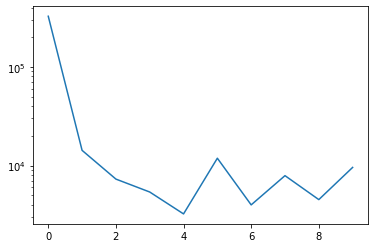

In [131]:
plt.plot(l)
plt.yscale('log')

## Plot Frames Loss

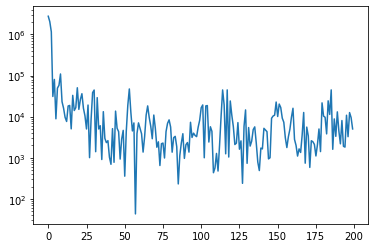

In [132]:
r = 1
plt.plot([sum(la[i:i+r])/r for i in range(0,len(la),r)])
plt.yscale('log')

## Prediction

In [ ]:
Parameters = torch.load("NewModelParams.pth")
cap = open_vid("VDB/G.mp4")
Video = get_frames(cap)

In [ ]:
for _ in range(5):
    Video[3] = Frame2Numpy(AddOneInc1(Frame2Torch(Video[3],Normalize=True)),Denormalize=True)

In [ ]:
ThroughFrames(Video)

In [ ]:
def GenerateFrames(frames, Params):
    C, P, F, B, KP = Extract(Params)
    N = len(P)
    Size = (320,320)
    generated_frames = []
    H,W = frames[0].shape[0],frames[0].shape[1]
    # Convert frames to Torch tensors, process them, and convert back to NumPy arrays
    for i in range(len(frames) - 2 * N):
        first, current, last = i, i + N // 2, i + N
        
        # Convert the current frame and surrounding frames to tensors
        current_frame_tensor = Frame2Torch(frames[current], Size,True)
        past_frames_tensors = [Frame2Torch(frames[first + j], Size,True) for j in range(N)]
        future_frames_tensors = [Frame2Torch(frames[current + 1 + j], Size,True) for j in range(N)]
        
        # Perform the forward pass to generate the new frame
        Pred = ObjFun(current_frame_tensor, past_frames_tensors, future_frames_tensors, C, P, F, B, KP)
        
        # Convert the predicted frame back to a NumPy array
        generated_frame = Frame2Numpy(Pred,Size=(W,H),Denormalize=True)
        generated_frames.append(generated_frame)
        
    return generated_frames

In [ ]:
PRED = GenerateFrames(Video[:20],Parameters)

In [ ]:
ThroughFrames(PRED)